#### Analyze snapshots

Notebook for analysing snapshots of Cluster example.

In [1]:
# load libraries
import sys  # load sys; needed for exit codes
import numpy as np  # load numpy
import h5py  # load h5py; needed to read snapshots
import matplotlib
import matplotlib.pyplot as plt  ## needs to be active for plotting!
import csv
import os

#Import a couple of useful modules
#(These are written by BJK rather than being native to the gadget4 codebase)
sys.path.append("../../")
import units as u
import analysis

matplotlib.rc_file_defaults()
FloatType = np.float64

In [2]:
#For the simulations here, we're simulating up to T = 1e-3 in code units, and writing snapshots every dt = 1e-5, so we should have 100 snapshots
snap_list = np.arange(100)

As in the Earth-Sun example, let's load in the trajectories of the particles for all the snapshots.

We'll call the simulation run with the standard `param.txt` file the '**Baseline**' simulation.

In [3]:
#This function loads a list of snapshots and gives the particle trajectories
#ts is the list of times of the snapshots 
#Pos_full are the particle positions, with dimensions (N_snapshots, N_particles, 3)
ts, Pos_full = analysis.load_all_snapshots("output", snap_list, cgs_units=True)

Now let's also load in some other simulation results, with a larger softening length (run with `param_soft.txt`). 

The gravitational force in `Gadget4` does not diverge as the particle separation goes to zero. Instead, it is softened (i.e. it goes to a finite value). The parameter $\epsilon$ is known as the softening length and sets the length-scale where this becomes relevant. In fact, in `Gadget4` the gravitational force is softened on scales below $L = 2.8 \epsilon$ and is exactly Newtonian on longer scales. 

The softening length $\epsilon$ is set by the parameter `SofteningComovingClass0` in the parameter file. The simulation run with `param_soft.txt` has a softening length which is 1000 times larger than in the baseline simulations. 

*Note that Gadget4 allows for different softening lengths for different particles. Assign particle types to a given softening class using the `SofteningClassOfPartTypeX` variables in `param.txt`, then assign each class a softening length using the `SofteningComovingClassY` variables.

In [4]:
ts_soft, Pos_full_soft = analysis.load_all_snapshots("output_soft", snap_list, cgs_units=True)

Now let's plot the trajectories of all the particles in the baseline and softened simulations side by side:

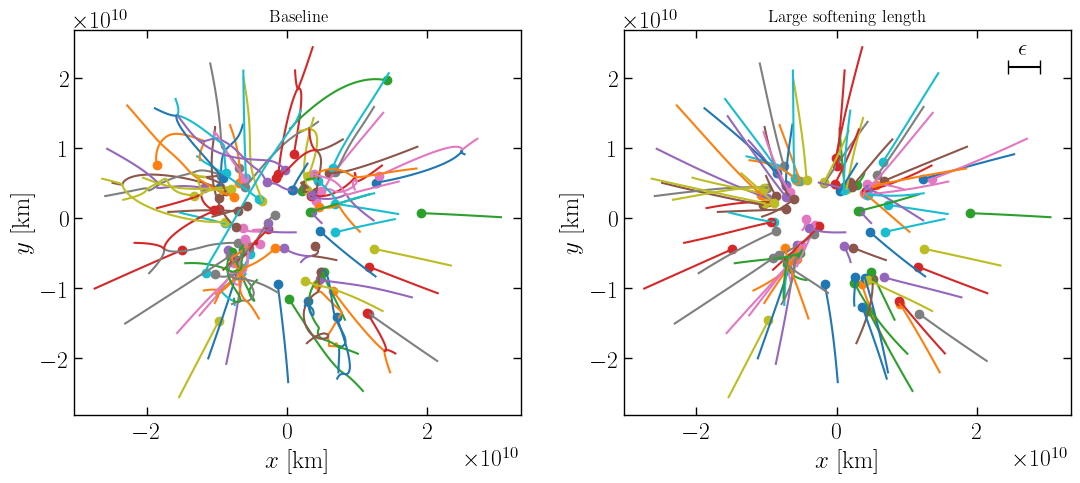

In [5]:
fig, axes = plt.subplots(figsize=(13,5), nrows=1, ncols=2)

#Loop over the two particles and the plot the (x,y) trajectories
for i_part in range(100):
    axes[0].plot(Pos_full[:,i_part,0]/u.km, Pos_full[:,i_part,1]/u.km)
    axes[0].scatter(Pos_full[-1,i_part,0]/u.km, Pos_full[-1,i_part,1]/u.km)
    
    axes[1].plot(Pos_full_soft[:,i_part,0]/u.km, Pos_full_soft[:,i_part,1]/u.km)
    axes[1].scatter(Pos_full_soft[-1,i_part,0]/u.km, Pos_full_soft[-1,i_part,1]/u.km)
    

x_max = axes[1].get_xlim()[1]
y_max = axes[1].get_ylim()[1]
Lsoft = 1e-10*u.Lcode/u.km
axes[1].errorbar(0.8*x_max, 0.8*y_max, xerr=0.5*Lsoft, yerr=None, fmt='', linestyle='-', color='k', capsize=5)
axes[1].text(0.8*x_max, 0.9*y_max, "$\epsilon$", ha = 'center', va='center')
    
axes[0].set_title("Baseline", fontsize=12)
axes[1].set_title("Large softening length", fontsize=12)
    
for ax in axes:
    ax.set_aspect("equal")
    ax.set_xlabel('$x$ [km]')
    ax.set_ylabel('$y$ [km]')

plt.show()

As you can see, the simulation with the large softening length is *over-softened*. The softening length is larger than the typical distance between some of the particles, meaning that close 2-body interactions are not being correctly resolved. Essentially, the softening is smoothing the density field of the particles; it's no longer a collection of point-like objects, it's more like a smooth density and the trajectories are much smoother as a result. 

Now we'll compare the standard simulation with a simulation with lower time-step resolution. 

The timestep resolution is controlled by the parameter $\eta$, which sets the timestep of each particle:
$$ \Delta t = \sqrt{2 \eta \epsilon/|\mathbf{a}|}$$
where $\epsilon$ is the softening length and $\mathbf{a}$ is the gravitational acceleration. 

In the parameter file, $\eta$ is set using `ErrTolIntAccuracy`. In addition, you can set `MaxSizeTimestep` in order to force the code not to take very large timesteps (even if the gravitational acceleration is small). 

The `lores` simulation (run with `params_lores.txt`) has a value of $\eta$ which is 10 times larger than the baseline simulation. Let's load it: 

In [6]:
snap_list = np.arange(100)
ts_lores, Pos_full_lores = analysis.load_all_snapshots("output_lores", snap_list, cgs_units=True)

Now let's plot the particle trajectories for the low timestep resolution simulation (`lores`) in magenta and the trajectories for the baseline simulation in black. If the two simulations give the same results, the black trajectories will lie on top of the magenta ones. Any magenta that we see indicates a difference between the two simulations.

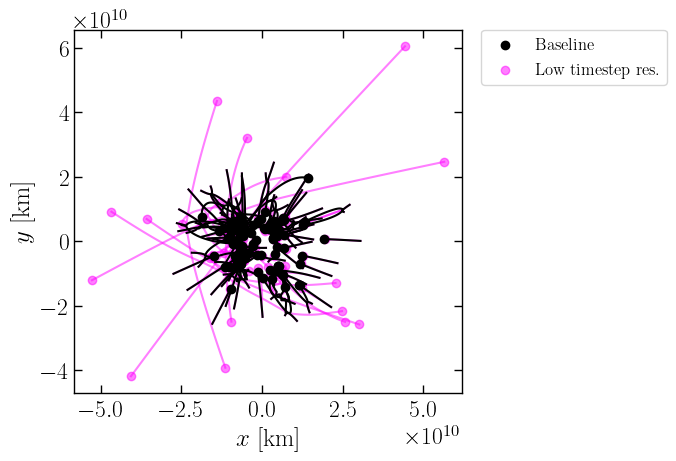

In [7]:
plt.figure(figsize=(5,5))

#Loop over the two particles and the plot the (x,y) trajectories
for i_part in range(100):
    lab = ""
    if (i_part == 0):
        lab = "Baseline"
    plt.plot(Pos_full[:,i_part,0]/u.km, Pos_full[:,i_part,1]/u.km,  color='k', zorder=10)
    plt.scatter(Pos_full[-1,i_part,0]/u.km, Pos_full[-1,i_part,1]/u.km,  color='k', zorder=10, label=lab)
    
    lab = ""
    if (i_part == 0):
        lab = "Low timestep res."
    plt.plot(Pos_full_lores[:,i_part,0]/u.km, Pos_full_lores[:,i_part,1]/u.km, alpha=0.5,color='magenta', zorder=0)
    plt.scatter(Pos_full_lores[-1,i_part,0]/u.km, Pos_full_lores[-1,i_part,1]/u.km, alpha=0.5, color='magenta', zorder=0, label=lab)
    
    
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
    
ax = plt.gca()
ax.set_aspect("equal")
ax.set_xlabel('$x$ [km]')
ax.set_ylabel('$y$ [km]')

plt.show()

As you can see, in most cases, the results are exactly the same, but occasionally you can see some magenta poking through. (Caveat: this might depend on your initial conditions.) Sometimes this is just a small deviation from the baseline simulation, but in other cases, you can end up with a particle in a completely different location! You should aim to tune the softening and the timestep resolution so that changing either of these parameters by a little doesn't affect the results. 